# Skillbox: **Обучение модели Data Science** (вебинар №2)

***
Записная книжка c домашним заданием **Ростова Павла**, mr.deff@gmail.com 

> перед выполнением задания, из багажа знаний было только знание основ Python + пройден интенсив от Skillbox по языку Python

****
### Объявляем необходимые библиотеки

- библиотеки из вебинара

In [148]:
import pandas as pd #библиотека для работы с данными
import numpy as np #библиотека для работы с векторами 
import matplotlib.pyplot as plt #библиотека для визуализации
from datetime import datetime #библиотека для работы с типом данных дата

from sklearn.linear_model import LinearRegression

- библиотеки найденный с примера на сайте [https://scikit-learn.org](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html#sphx-glr-auto-examples-model-selection-plot-underfitting-overfitting-py)

In [149]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

### Объявление переменных
в домашнем задании использовалась история изменения курса USD к рублю с сайта www.cbr.ru в период [с 18.06.2000 г. по 25.06.2019 г.](https://www.cbr.ru/currency_base/dynamics/?UniDbQuery.Posted=True&UniDbQuery.mode=1&UniDbQuery.date_req1=&UniDbQuery.date_req2=&UniDbQuery.VAL_NM_RQ=R01235&UniDbQuery.FromDate=18.06.2000&UniDbQuery.ToDate=25.06.2019)

Из формата **MS Excel** в формат **CSV** переводилось с помощью **MS Office 2016** 

In [150]:
f_name = "RC_F18_06_2000_T25_06_2019.csv" # файл с историей USD 

In [151]:
money = pd.read_csv(f_name, sep=';')

In [152]:
money.head(5) # проверка загрузки данных

,nominal,data,curs,cdx
0,1,20.06.2000,"28,2400",Доллар США
1,1,21.06.2000,"28,2300",Доллар США
2,1,22.06.2000,"28,2200",Доллар США
3,1,23.06.2000,"28,1900",Доллар США
4,1,24.06.2000,"28,1700",Доллар США


In [153]:
target_columns = ["data", "curs"] # определение интересующих полей из первоначальной выборки
money = money[target_columns] # отсечение не нужных полей
money.head(5) # проверка результата

,data,curs
0,20.06.2000,"28,2400"
1,21.06.2000,"28,2300"
2,22.06.2000,"28,2200"
3,23.06.2000,"28,1900"
4,24.06.2000,"28,1700"


In [154]:
''' переименовываем поля в нужный нам формат'''
real_columns = ["date", "value"]
money.columns = real_columns
money.head(5)

,date,value
0,20.06.2000,"28,2400"
1,21.06.2000,"28,2300"
2,22.06.2000,"28,2200"
3,23.06.2000,"28,1900"
4,24.06.2000,"28,1700"


In [155]:
money.info() # информация по нашей выборке

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4722 entries, 0 to 4721
Data columns (total 2 columns):
date     4722 non-null object
value    4722 non-null object
dtypes: object(2)
memory usage: 73.9+ KB


In [156]:
''' объявляем функции для конвертирования текстовых данных в выборке '''
def convert_value(val):
    if type(val) == str:
        return float(val.replace(",","."))
    else:
        return val
    

def convert_date(val):
#     ''' 
#         необходимо обратить внимание на формат даты в исходных данных и подставить соответствующую маску
#         возможные варианты:
#             21/09/2019 --> "%d/%m/%Y"
#             09/21/2019 --> "%m/%m/%Y"
#             21.09.2019 --> "%d.%m.%Y"
#             09.21.2019 --> "%m.%m.%Y"
#     '''
    if type(val) == str:
        return datetime.strptime(val, "%d.%m.%Y")
    else:
        val

In [157]:
convert_value("28,1700")

28.17

In [158]:
type(money.date[0])

str

In [159]:
print(convert_date(money.date[11]))

2000-07-05 00:00:00


In [160]:
'''конвертируем строковые данные в исходной выборке в формат даты и числа с плавающей точкой '''
money["date"] = money["date"].apply(convert_date)
money["value"] = money["value"].apply(convert_value)
money.head(5)

,date,value
0,2000-06-20,28.24
1,2000-06-21,28.23
2,2000-06-22,28.22
3,2000-06-23,28.19
4,2000-06-24,28.17


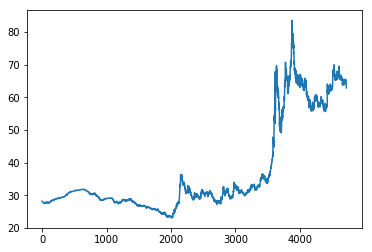

In [161]:
plt.plot(money["value"]) # прорисовываем график

- использование функции для вывода графика с подписями даты по оси Х [matplotlib.pyplot.plot_date](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot_date.html?highlight=plot_date#matplotlib.pyplot.plot_date)

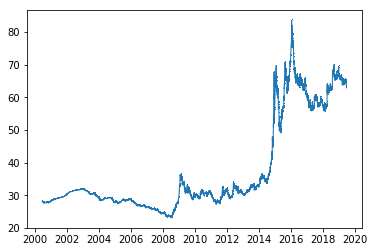

In [162]:
plt.plot_date(money["date"], money["value"], label = "real", marker=',', linestyle="-", linewidth = '1')

In [163]:
''' добавляем в выборку поля с индефикатором записи - порядковый номер'''
money["id"] = range(len(money))
money.head(5)

,date,value,id
0,2000-06-20,28.24,0
1,2000-06-21,28.23,1
2,2000-06-22,28.22,2
3,2000-06-23,28.19,3
4,2000-06-24,28.17,4


### Применение линейной регрессии 
- в расчетах приведены различные варианты соотношения исходной выборки для обучения модели и тестирования в попорциях: **50/50, 80/20, 90/10 ** 

<Figure size 432x288 with 0 Axes>

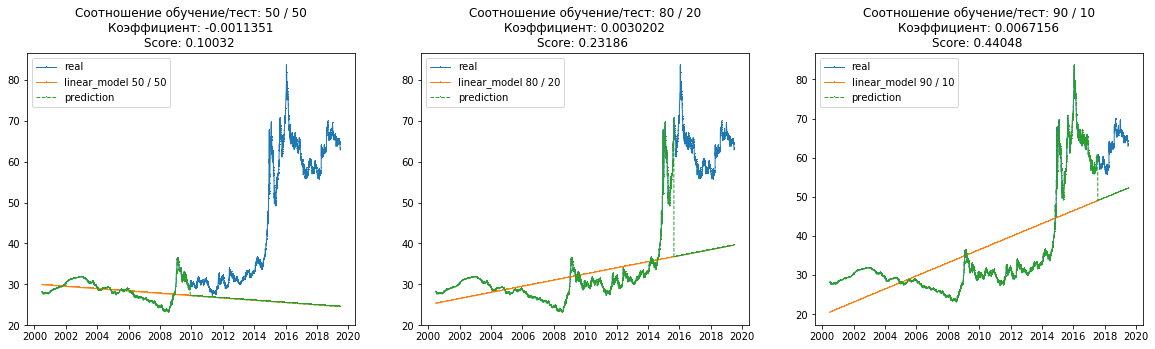

In [164]:
ratios = [.5, .8, .9]

plt.figure(1)
plt.figure(figsize=(20, 5)) # Задаем размерность полотна графика

for i in range(len(ratios)):
    ratio = ratios[i]
    
    end = int(len(money) * ratio) # задаем границу среза данных для обучения и тестирования
    X = money[["id"]][:end]  # Задаем глубину ряда данных для обучения
    y = money["value"][:end] # Задаем значения, соответствующие ряду данных  
    
    X_test = money[["id"]][end:] # Остаток данных из исходной выборки задаем для тестирования 
    y_test = money[["value"]][end:] 
    
    reg = LinearRegression().fit(X,y) # обучение модели
       
    y_pred = reg.predict(X_test) # тестирование модели
    ratio_name = f"{round(ratio * 100)} / {round((1-ratio)*100)}" # пропорция в строковом значении
    
    reg_coef, reg_score = reg.coef_[0], reg.score(X,y)  #статистика модели 
    
    ''' Отрисовка графиков'''
    ax = plt.subplot(1, len(ratios), i + 1)
#     plt.setp(ax, xticks=(), yticks=())
    plt.plot_date(money["date"], money["value"], label = "real", marker=',', linestyle="-", linewidth = '1')
    plt.plot_date(money["date"], reg.predict(money[["id"]]), label = f"linear_model {ratio_name}", marker=',', linestyle="-", linewidth = '1')
    plt.plot_date(money["date"], list(y)+list(y_pred), label = "prediction", marker=',', linestyle="--", linewidth = '1')
    plt.title(f"Соотношение обучение/тест: {ratio_name}\nКоэффициент: {reg_coef:.5}\nScore: {reg_score:.5} ")
    plt.legend()
plt.show()

### Применение полиномной регрессии 
- в расчетах приведены различные варианты соотношения исходной выборки для обучения модели и тестирования в попорциях:**50/50, 80/20, 90/10** 
- в расчетах используется различные варианты степеней для полиномной регрессии: **2, 4, 5**

<Figure size 432x288 with 0 Axes>

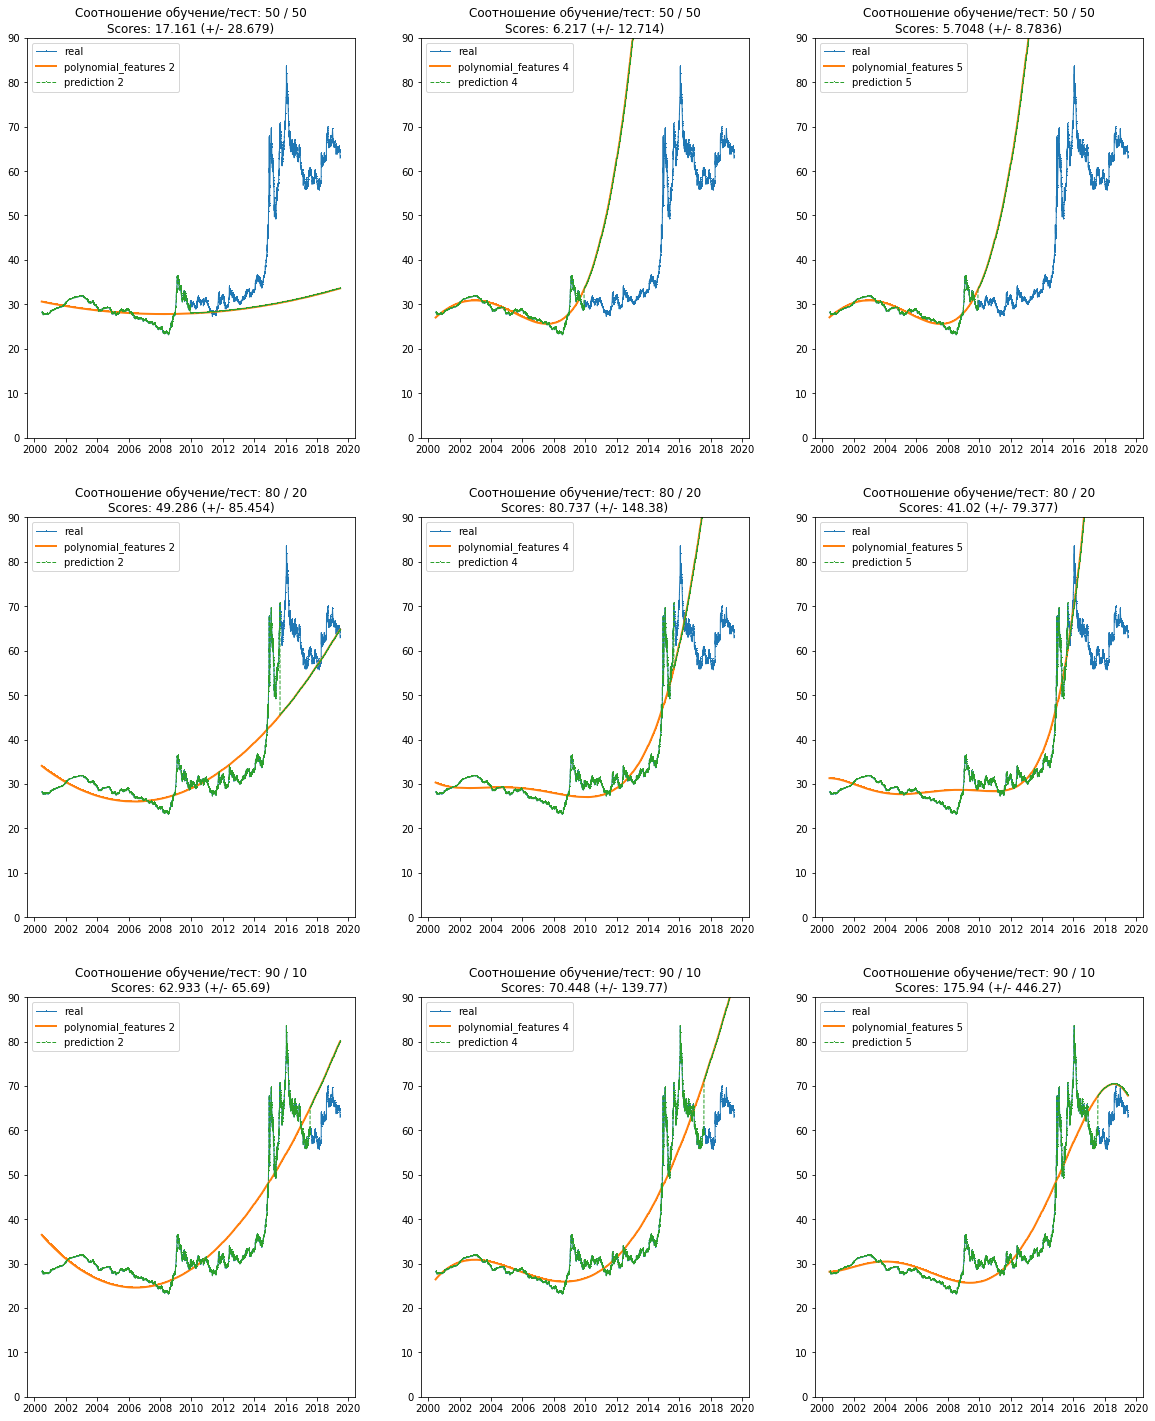

In [165]:
degrees = [2, 4, 5]
ratios = [.5, .8, .9]

plt.figure(1)
plt.figure(figsize=(20, 25))
plt_num = 1

for i in range(len(degrees)):
    ratio = ratios[i]
    
    end = int(len(money) * ratio)
    X = money[["id"]][:end]
    y = money["value"][:end]
    
    X_test = money[["id"]][end:]
    y_test = money[["value"]][end:]
       
    ratio_name = f"{round(ratio * 100)} / {round((1-ratio)*100)}"
    
    for j in range(len(degrees)):
        degr = degrees[j]
        
        ax = plt.subplot(len(ratios), len(degrees), plt_num )

        plt.plot_date(money["date"], money["value"], label = "real", marker=',', linestyle="-", linewidth = '1')
        
        polynomial_features = PolynomialFeatures(degree=degr, include_bias=False)
        linear_regression = LinearRegression()
    
        pipeline = Pipeline([("polynomial_features", polynomial_features), ("linear_regression", linear_regression)])
        pipeline.fit(X, y)
        y_pred = pipeline.predict(X_test)
        
        # Evaluate the models using crossvalidation
        scores = cross_val_score(pipeline, X, y, scoring="neg_mean_squared_error", cv=10)
    
        plt.plot_date(money["date"], pipeline.predict(money[["id"]]), label = f"polynomial_features {degr}", marker=',', linestyle="-", linewidth = '2')
        plt.plot_date(money["date"], list(y)+list(y_pred), label = f"prediction {degr}", marker=',', linestyle="--", linewidth = '1')
        plt.ylim((0, 90))
    
        plt.title(f"Соотношение обучение/тест: {ratio_name}\nScores: {-scores.mean():.5} (+/- {scores.std():.5})") 
        plt.legend()
        plt_num = plt_num + 1 
        
plt.show()